In [1]:
import numpy as np
import torch
from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer, util
import json
from tqdm.auto import tqdm

In [2]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2', device='cuda:1')

In [4]:
import pandas as pd

df= pd.read_csv("prompts_generation_data.csv")

In [5]:
import numpy as np

for l in np.unique(df['label']):
    print(l, len(df[df['label']==l]))

affiliation 70
denouncing 316
facts 469
humor 260
hypocrisy 248
positive tone 136
question 97
support 75
warning 79


In [4]:
df.sort_values("processed_counterspeech", inplace=True)
  
# dropping ALL duplicate values
df.drop_duplicates(subset="processed_counterspeech",
                      keep='first', inplace=True)

In [5]:
df.reset_index(inplace=True,drop=True)
df.head()

,label,processed_counterspeech
0,denouncing,007 now that is just racist
1,facts,1 a quick google search shows that your stats ...
2,facts,100 million compare to 1 billion lebron can ge...
3,facts,100 of the unemployed muslim stats i read on t...
4,humor,100 that later we will find out he is gay and ...


In [6]:
labels = np.unique(df['label'])

for l in labels:
    print(l, len(df[df['label']==l]))


# data.reset_index(inplace=True,drop=True)

# embs = model.encode(df['processed_counterspeech'])

affiliation 70
denouncing 268
facts 377
humor 244
hypocrisy 226
positive tone 135
question 73
support 75
warning 79


affiliation


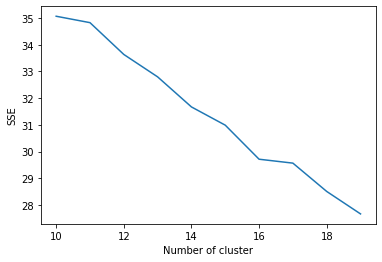

denouncing


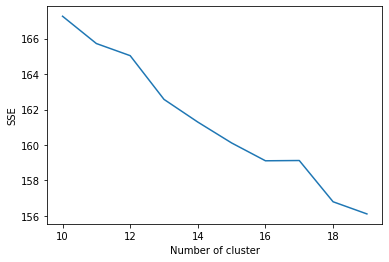

facts


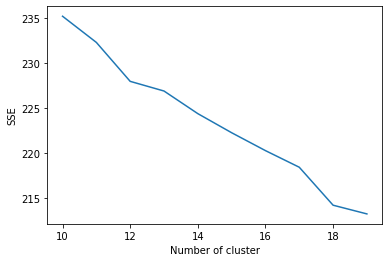

humor


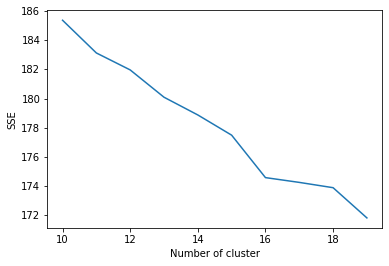

hypocrisy


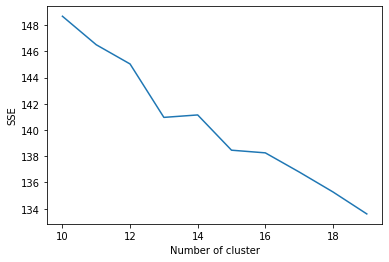

positive tone


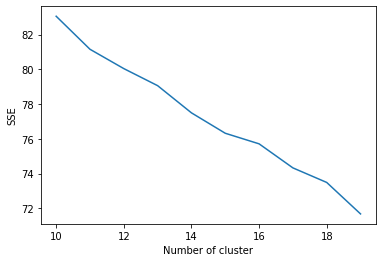

question


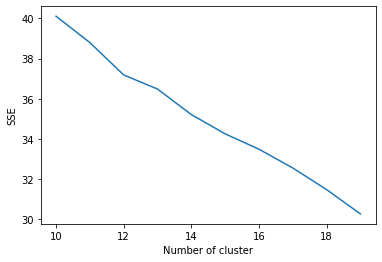

support


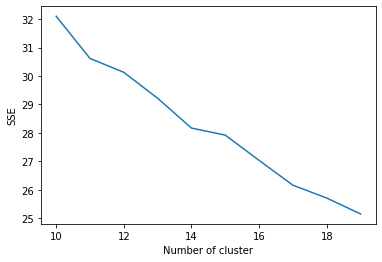

warning


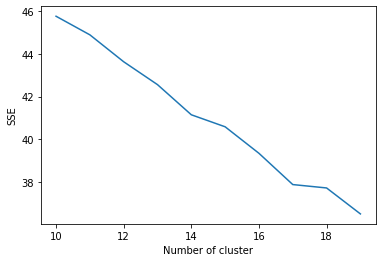

In [7]:
from sklearn.cluster import Birch, KMeans
from tqdm.auto import tqdm
import matplotlib.pyplot as plt


for l in labels:
    data = df[df['label']==l]
    print(l)
    data.reset_index(inplace=True,drop=True)
    embs = model.encode(data['processed_counterspeech'])
#     print(embs.shape[0])
    
    sse = {}

    for k in tqdm(range(10, 20)):
        kmeans = KMeans(n_clusters=k, max_iter=1000).fit(embs)
    #     data["clusters"] = kmeans.labels_
        #print(data["clusters"])
        sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center

    plt.figure()
    plt.plot(list(sse.keys()), list(sse.values()))
    plt.xlabel("Number of cluster")
    plt.ylabel("SSE")
    plt.show()

In [10]:
n_cl = [16,16,18,16,15,18,18,14,17]

from sklearn.cluster import Birch, KMeans
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import pairwise_distances

j = 0
rep = dict()

for l in tqdm(labels):
    data = df[df['label']==l]
    print(l)
    data.reset_index(inplace=True,drop=True)
    embs = model.encode(data['processed_counterspeech'])
    
    kmeans = KMeans(n_clusters=n_cl[j], max_iter=1000).fit(embs)
    j += 1
    cluster_centers = kmeans.cluster_centers_
    
    num_clusters = cluster_centers.shape[0]
    closest_points = np.zeros((num_clusters, embs.shape[1]))

    closests = []
    sizes = []
    for i in range(num_clusters):
        cluster = embs[kmeans.labels_ == i]
        sizes.append(cluster.shape[0])
        
    ss = list(np.argsort(sizes))
    ss.reverse()
    
    for i in ss[:10]:
        print(sizes[i])
            
        center = cluster_centers[i, :]
        distances = pairwise_distances(embs, center.reshape(1, -1), metric='euclidean')
        distances = np.squeeze(distances).tolist()
        closest_point_index = np.argsort(distances)[:3]
        closests += list(data.iloc[closest_point_index]['processed_counterspeech'])
        
    rep[l] = set(closests)
    

affiliation
13
9
5
5
5
5
5
4
4
3
denouncing
32
31
31
23
23
17
16
16
15
12
facts
46
33
32
27
23
22
22
21
21
20
humor
26
21
20
18
18
17
16
16
16
14
hypocrisy
29
27
24
19
19
17
15
13
12
12
positive tone
19
15
12
10
10
9
9
8
8
8
question
12
9
6
6
5
4
4
3
3
3
support
14
11
9
8
8
5
5
4
3
2
warning
10
9
9
7
6
5
4
4
4
3



In [11]:
len(rep['question'])

30

In [12]:
prompts = []
labels = []

for k,v in rep.items():
    for cs in v:
        prompts.append(' '.join(cs.split()[:4]))
        labels.append(k)

In [13]:
ndf = pd.DataFrame({'prompt':prompts, 'label':labels})

ndf

,prompt,label
0,ya know i always,affiliation
1,when i watch this,affiliation
2,i feel very sorry,affiliation
3,i find it frightening,affiliation
4,as a jew id,affiliation
...,...,...
263,jmczzz007 please put them,warning
264,all kids there will,warning
265,patriotsue look please take,warning
266,every crime is a,warning


In [14]:
ndf.to_csv('prompts.csv')

In [1]:
print(9)

9


In [2]:
import pandas as pd

ndf = pd.read_csv('prompts.csv')
ndf

,Unnamed: 0,prompt,label
0,0,ya know i always,affiliation
1,1,when i watch this,affiliation
2,2,i feel very sorry,affiliation
3,3,i find it frightening,affiliation
4,4,as a jew id,affiliation
...,...,...,...
263,263,jmczzz007 please put them,warning
264,264,all kids there will,warning
265,265,patriotsue look please take,warning
266,266,every crime is a,warning
